# Demonstration of `DroneWQ` functions and processing code

## Summary 

This notebook provides an example workflow of DroneWQ using multispectral images collected by the MicaSense RedEdge-MX sensor over eastern Lake Erie on August 17, 2022. The workflow processes raw imagery to remote sensing reflectance and applies bio-optical algorithms to retrieve chlorophyll a concentrations. It georeferences the images producing a final chlorophyll a mosaic of the full dataset. 

## Contents

1. [Setup](#1.-Setup)
2. [View metadata](#2.-View-metadata)
3. [Process raw to Rrs](#3.-Process-raw-imagery-to-remote-sensing-reflectance-(Rrs)-and-visualize-data)
4. [Convert to point samples](#4.-Convert-to-point-samples)
5. [Apply bio-optical algorithms](#5.-Apply-bio-optical-algorithms)
6. [Georeference and mosaic](#6.-Georeference-and-mosaic-chlorophyll-a-images)

## 1. Setup

Pull in all the libraries needed for this notebook.

TODO: Figure out which libraries are needed here vs utils.py. Make sure utils.py libraries are all needed

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from cartopy.crs import Mercator
import matplotlib.image as mpimg

plt.rcParams['mathtext.default'] = 'regular'

from utils import *

Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want but keep the rest exactly as named here):
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to your main_dir below. Here, we have the main_dir called 'Lake_Erie'.

In [2]:
project_path = os.path.join('Lake_Erie') 
project_path

'Lake_Erie'

## 2. View metadata

MicaSense raw images contain metatdata including imager information, GPS coordianates, and more. We can use the `write_metadata_csv()` function to extract image metadata and save it as .csv. 

Let's open the first five lines of the .csv to take a look.

In [204]:
write_metadata_csv(img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs'),
                                                            csv_output_path=project_path)

img_metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
img_metadata.head()

Loading ImageSet from: Lake_Erie/raw_water_imgs


,filename,dirname,DateStamp,TimeStamp,Latitude,LatitudeRef,Longitude,LongitudeRef,Altitude,SensorX,...,FocalLength,Yaw,Pitch,Roll,SolarElevation,ImageWidth,ImageHeight,XResolution,YResolution,ResolutionUnits
0,capture_1.tif,Lake_Erie/capture_1.tif,2022-08-17,15:37:04,41.828528,N,-83.398762,W,265.061,4.8,...,5.43432,218.376096,25.899967,335.837017,0.895362,1280,960,266.666667,266.666667,mm
1,capture_2.tif,Lake_Erie/capture_2.tif,2022-08-17,15:37:08,41.828670,N,-83.398764,W,265.554,4.8,...,5.43432,221.427592,16.821391,341.184053,0.895530,1280,960,266.666667,266.666667,mm
2,capture_3.tif,Lake_Erie/capture_3.tif,2022-08-17,15:37:10,41.828809,N,-83.398760,W,265.968,4.8,...,5.43432,218.898605,16.695405,343.643092,0.895655,1280,960,266.666667,266.666667,mm
3,capture_4.tif,Lake_Erie/capture_4.tif,2022-08-17,15:37:13,41.828956,N,-83.398761,W,266.420,4.8,...,5.43432,216.716936,18.188710,345.889851,0.895738,1280,960,266.666667,266.666667,mm
4,capture_5.tif,Lake_Erie/capture_5.tif,2022-08-17,15:37:16,41.829081,N,-83.398763,W,267.018,4.8,...,5.43432,214.429136,18.385695,347.772515,0.895863,1280,960,266.666667,266.666667,mm


We can plot the altitude and lat,lon location metadata of the image captures to get a sense of the flight plan.

Text(0, 0.5, 'Yaw')

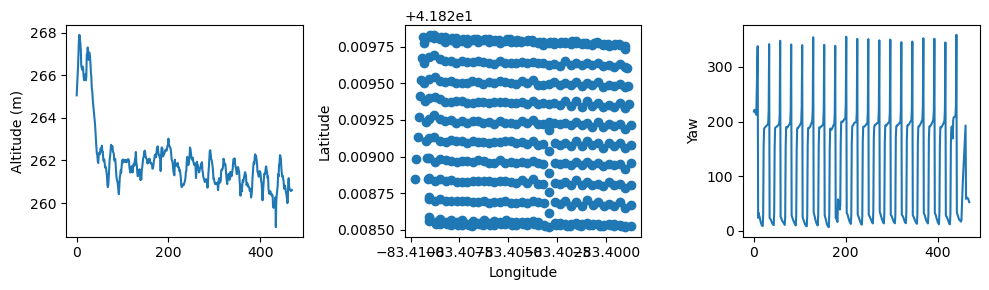

In [205]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='tight')

ax[0].plot(list(range(len(img_metadata))),img_metadata['Altitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(img_metadata['Longitude'], img_metadata['Latitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

ax[2].plot(list(range(len(img_metadata))),img_metadata['Yaw'])
ax[2].set_ylabel('Yaw')

## 3. Process raw imagery to remote sensing reflectance (Rrs) and visualize data

Now let's get to processing. 
The `process_raw_to_rrs()` function has a number of options that you can see here:

In [43]:
?process_raw_to_rrs

Signature:
process_raw_to_rrs(
    main_dir,
    rrs_dir_name,
    output_csv_path,
    lw_method='mobley_rho_method',
    mask_pixels=False,
    random_n=10,
    pixel_masking_method='value_threshold',
    mask_std_factor=1,
    nir_threshold=0.01,
    green_threshold=0.005,
    ed_method='dls_ed',
    overwrite_lt_lw=False,
    clean_intermediates=True,
)
Docstring:
This functions is the main processing script that processs raw imagery to units of remote sensing reflectance (Rrs). Users can select which processing parameters to use to calculate Rrs.

Inputs: 
main_dir: A string containing the main image directory
rrs_dir_name: A string containing the directory filepath of new rrs images
output_csv_path: A string containing the filepath to write the metadata.csv 
lw_method: Method used to calculate water leaving radiance. Default is mobley_rho_method().
random_n: The amount of random images to calculate ambient NIR level. Default is 10. Only need if lw_method = 'hedley_method'
mask_pi

For this example, we're calculating water leaving radiance (Lw) using the Hedley approach, calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS). We are applying the default masking procedure. We'll save processed images out two directories called `rrs_hedley` and `masked_rrs_hedley`. Please see paper.md for more information on the different methods used here. 

In summary, this code will process: Raw -> Lt -> Lw (Hedley method) -> Rrs (using Ed from DLS) with pixel masking.

Note that we are changing the default nir_threshold for pixel masking from 0.01 to 0.02 since 0.01 was not high enough to mask glint pixels in this dataset. It is important to consider these values since they may change according to your dataset. 

In [207]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', 
                   random_n=10, mask_pixels=True, pixel_masking_method='value_threshold', nir_threshold=0.02, ed_method='dls_ed', 
                   overwrite_lt_lw=False, clean_intermediates=False)


Loading ImageSet from: Lake_Erie/align_img
Processing a total of 2351 images or 470 captures.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: Lake_Erie/raw_water_imgs
Loading ImageSet from: Lake_Erie/align_img
used warp dir Lake_Erie/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 1
Finished aligning band 4
Saving time: 0:07:38.814627
Alignment+Saving rate: 1.02 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: Lake_Erie/raw_water_imgs
All data has been saved as Rrs using the hedley_method to calculate Lw and normalized by dls_ed irradiance.
Masking pixels using NIR and green Rrs thresholds


True

To grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows you to apply an altitude cutoff and limit the number of files being opened. 

In [29]:
?retrieve_imgs_and_metadata

Signature:
retrieve_imgs_and_metadata(
    img_dir,
    count=10000,
    start=0,
    altitude_cutoff=0,
    sky=False,
    random=False,
)
Docstring:
This function is the main interface we expect the user to use when grabbing a subset of imagery from any stage in processing. This returns the images as a numpy array and metadata as a pandas dataframe. 

Inputs:
img_dir: A string containing the directory filepath of images to be retrieved
count: The amount of images you want to list. Default is 10000
start: The number of image to start on. Default is 0 (first image in img_dir). 
random: A boolean to load random images. Default is False

Outputs: A multidimensional numpy array of all image captures in a directory and a Pandas dataframe of image metadata. 
File:      /glusteruser/awindled/DroneWQ/utils.py
Type:      function

Note that this will open as many files as you ask and if you have 1000+ images this is likely more than you can load into memory. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

Let's retrieve the Rrs data (5 bands) and visualize the first 5 images:

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


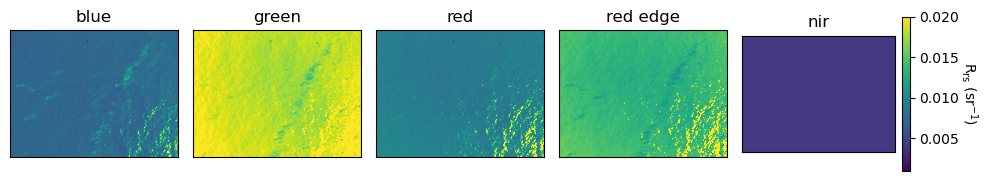

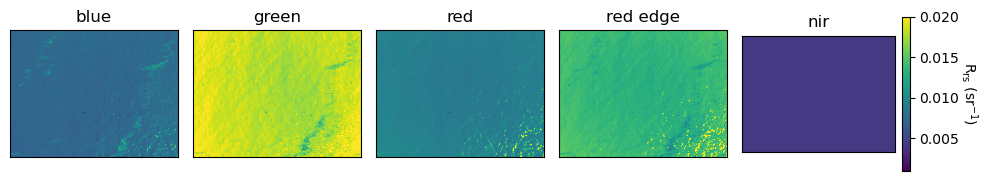

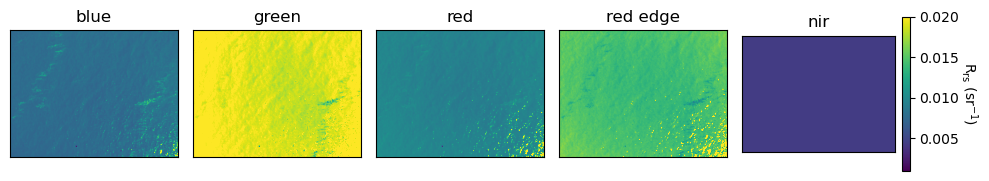

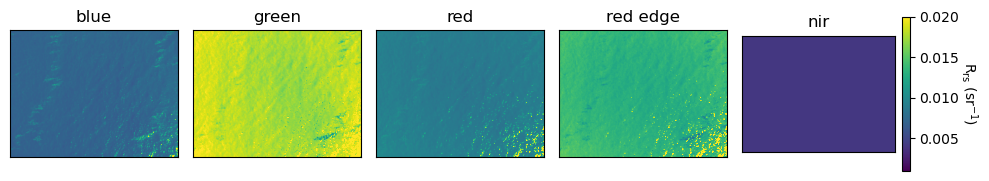

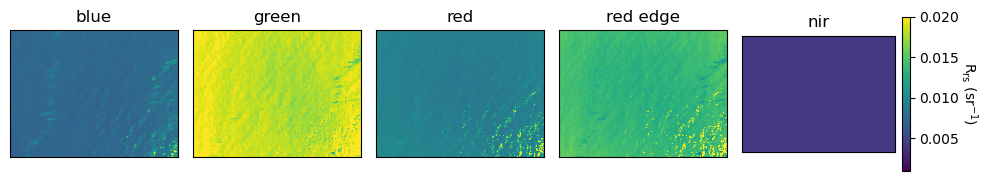

In [208]:
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'rrs_hedley'), start=0, count=5)
print(img_metadata.index)

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i], cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

We can also visualize the masked Rrs:

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


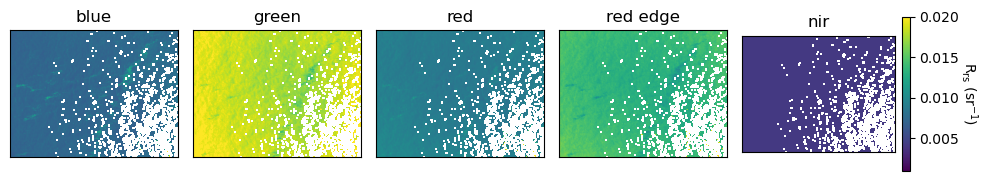

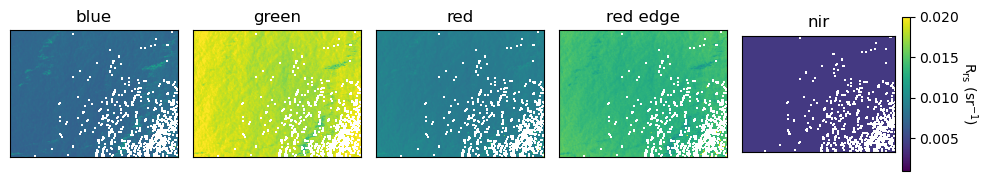

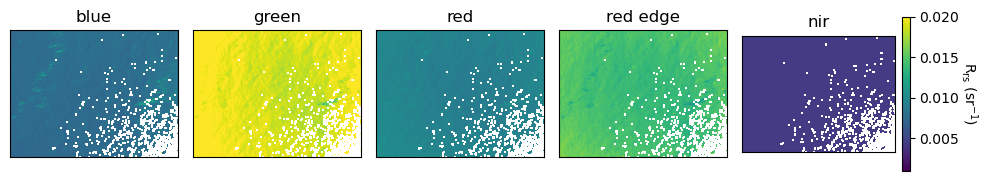

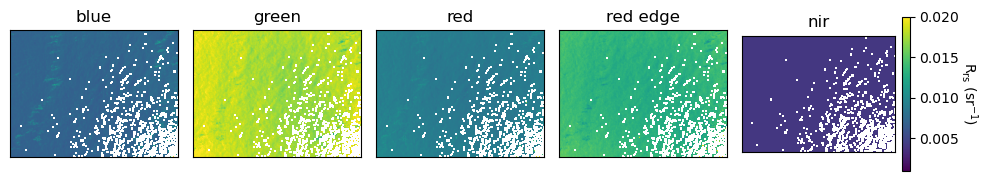

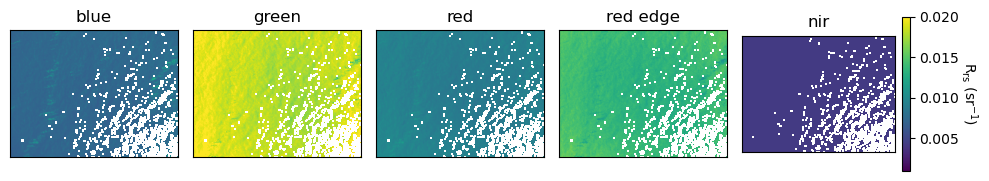

In [221]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_rrs_hedley'), start=0, count=5)
print(img_metadata.index)

for j in range(len(masked_rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

Let's plot the masked Rrs spectra of the first 25 images:

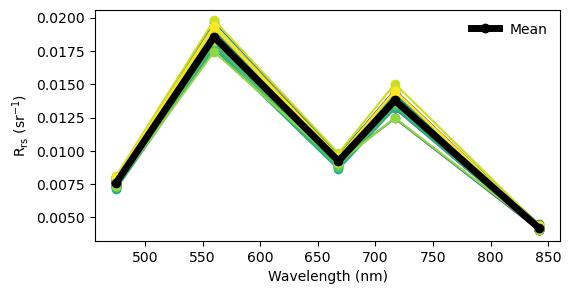

In [210]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_rrs_hedley'), count=25)

fig, ax = plt.subplots(1,1, figsize=(6,3))

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)), marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$R_{rs}\ (sr^{-1}$)') 
plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

plt.legend(frameon=False)

Let's compare this Rrs spectra to Rrs retrived by a satellite at the same location and time. Below is a plot of Rrs from the Ocean Land Color Imager (OLCI) on board the European satellite, Sentinel-3A. OLCI collects in a few more bands which is where there are more points on the plot. However, the shape looks similar to the MicaSense retrieved Rrs. The troughs at 475 nm and 668 nm is associated with chlorophyll absorption and the peak at 717 nm is likely due to phytoplankton particle scattering. 

<img src="figs/OLCI_Rrs_Lake_Erie.png" width=560 height=500/>

Let's plot the Lt, Lw, Ed spectra as well. First, we need to retrieve all the data.

In [212]:
lt_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs', count=25)
lw_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lw_imgs', count=25)
dls_ed = pd.read_csv(project_path+'/dls_ed.csv')
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley', count=25)
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley', count=25)

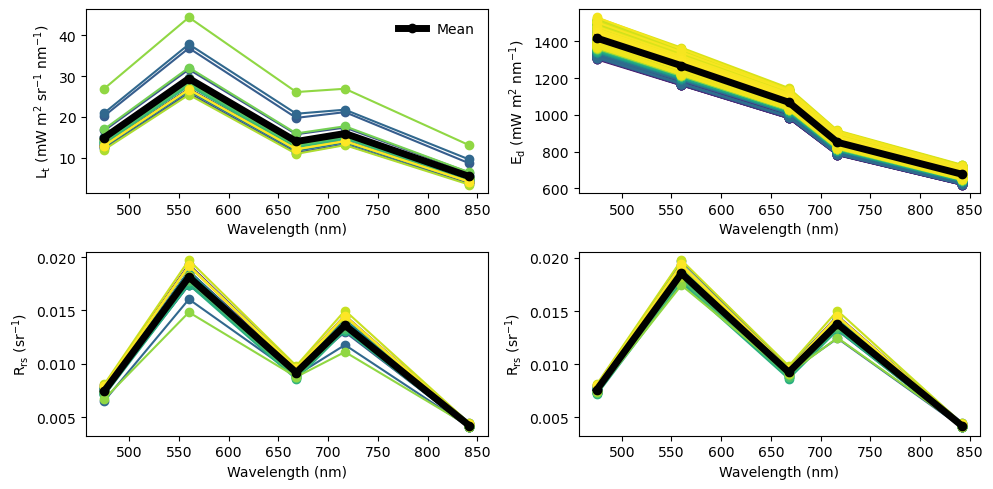

In [213]:
fig, axs = plt.subplots(2,2, figsize=(10,5))

axs = axs.ravel()

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

#lt
for i in range(len(lt_imgs)):
    axs[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
axs[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')
axs[0].legend(frameon=False)

#dls ed
ed = pd.read_csv(project_path+'/dls_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    axs[1].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
axs[1].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')

#rrs_imgs_hedley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_hedley)))

for i in range(len(rrs_imgs_hedley)):
    axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')


#rrs_imgs_hedley_masked
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[3].set_xlabel('Wavelength (nm)')
    axs[3].set_ylabel('$R_{rs}\ (sr^{-1}$)')   
axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

fig.tight_layout() 


The `process_raw_to_rrs()` function also saves images processed to total radiance (Lt) as stacked red-green-blue (RGB) .jpg's in a folder called 'lt_thumbnails'. This is an easy way to quickly view the images to see what the water surface looked like. Let's open a few to take a look:

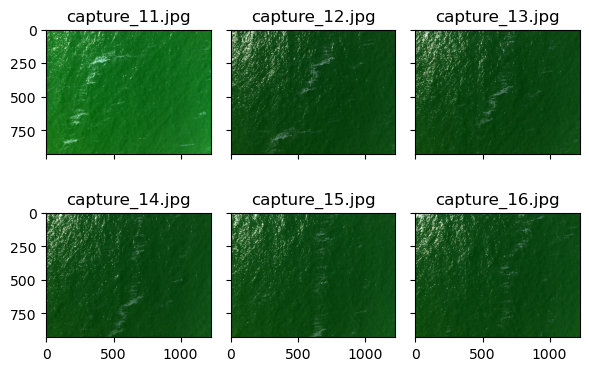

In [101]:
def capture_path_to_int(path : str) -> int:
    return int(os.path.basename(path).split('_')[-1].split('.')[0])

lt_thumbnails = sorted(glob.glob(project_path + '/lt_thumbnails/*.jpg'), key = capture_path_to_int)[10:]

fig, axs = plt.subplots(2,3, figsize=(6,4), sharex=True, sharey=True, layout='tight')
axs = axs.ravel()

for i in range(6):
    image = mpimg.imread(lt_thumbnails[i])
    axs[i].imshow(image)
    axs[i].set_title(os.path.basename(lt_thumbnails[i]))

plt.show()

## 4. Convert to point samples

You might be interested in averaging values for every image, to work with point samples. This code calculates the mean Rrs across bands and saves them to a Pandas dataframe with the dirname, lat, and lon.

TODO: Should this be median?

In [216]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

rrs_blue = []
rrs_green = []
rrs_red = []
rrs_rededge = []
rrs_nir= []

for i in range(len(masked_rrs_imgs_hedley)):
    rrs_blue.append(np.nanmean(masked_rrs_imgs_hedley[i,0,:,:]))
    rrs_green.append(np.nanmean(masked_rrs_imgs_hedley[i,1,:,:]))
    rrs_red.append(np.nanmean(masked_rrs_imgs_hedley[i,2,:,:]))
    rrs_rededge.append(np.nanmean(masked_rrs_imgs_hedley[i,3,:,:]))
    rrs_nir.append(np.nanmean(masked_rrs_imgs_hedley[i,4,:,:]))
    
df = img_metadata[['dirname', 'Latitude', 'Longitude']]
df['rrs_blue'] = rrs_blue
df['rrs_green'] = rrs_green
df['rrs_red'] = rrs_red
df['rrs_rededge'] = rrs_rededge
df['rrs_nir'] = rrs_nir    
df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir
filename,,,,,,,,
capture_1.tif,Lake_Erie/capture_1.tif,41.828528,-83.398762,0.007745,0.018765,0.009435,0.014060,0.004190
capture_2.tif,Lake_Erie/capture_2.tif,41.828670,-83.398764,0.007574,0.018275,0.009231,0.013695,0.004139
capture_3.tif,Lake_Erie/capture_3.tif,41.828809,-83.398760,0.008004,0.019353,0.009626,0.014550,0.004365
capture_4.tif,Lake_Erie/capture_4.tif,41.828956,-83.398761,0.007388,0.017988,0.009134,0.013514,0.004087
capture_5.tif,Lake_Erie/capture_5.tif,41.829081,-83.398763,0.007611,0.018548,0.009359,0.013870,0.004196


Easy to save as a .csv:

In [222]:
df.to_csv(project_path + '/mean_rrs.csv')

## 5. Apply bio-optical algorithms

We can also apply bio-optical algorithms to derive chlorophyll a and total suspended matter (TSM) concentrations. See the paper.md for more information on each algorithm. Here, we are applying the blended NASA chlorophyll a algorithm (Hu et al., 2019). 

In [223]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])
print(chl_hu_ocx_imgs.shape)

(470, 928, 1227)


Let's take a quick look at a histogram of all chl values:

11.140011


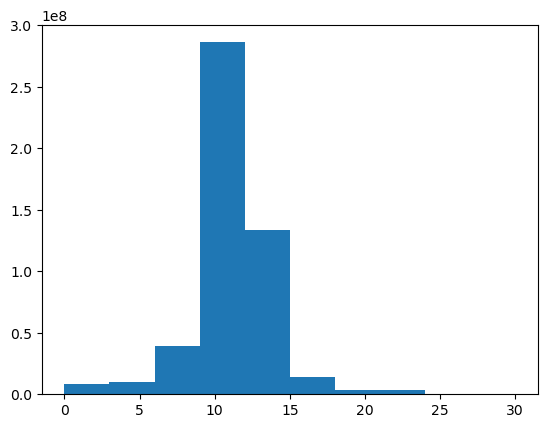

In [224]:
plt.hist(chl_hu_ocx_imgs.ravel(), range=[0, 30])
print(np.nanmedian(chl_hu_ocx_imgs))

The median value looks to be around 11 mg $m^{-3}$, which is reasonable for inland waters. 

Now, we can save new .tifs processed with this algorithm. 

TODO: get rid of italics here ^^

In [225]:
save_wq_imgs(main_dir=project_path, rrs_img_dir='masked_rrs_hedley', 
             wq_dir_name='masked_chl_hu_ocx_imgs', wq_alg ='chl_hu_ocx') 

100%|██████████| 470/470 [03:47<00:00,  2.07it/s]


Let's visualize a few chl a images.

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif', 'capture_6.tif'],
      dtype='object', name='filename')


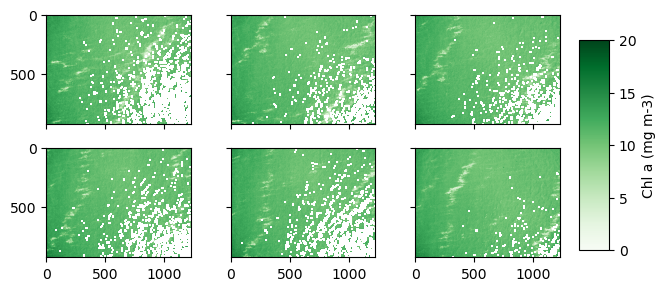

In [255]:
chl_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_chl_hu_ocx_imgs'), start=0, count=6)
print(img_metadata.index)

fig, axs = plt.subplots(2,3, figsize=(6,3), sharex=True, sharey=True, layout='tight')

axs = axs.ravel()

for i in range(6):
    im = axs[i].imshow(chl_imgs[i,0,:,:], cmap='Greens', vmin=0, vmax=20)

cbar_ax = fig.add_axes([0.99, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Chl a (mg m-3)')

plt.show()

We can also save average chl-a/TSM concentrations for each image in dataframe to use as point data:

In [227]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

tsm_nechad_imgs = tsm_nechad(Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

chl_hu_ocx_values = []
tsm_nechad_values = []

for i in range(len(masked_rrs_imgs_hedley)):
    chl_hu_ocx_values.append(np.nanmedian(chl_hu_ocx_imgs[i,:,:]))
    tsm_nechad_values.append(np.nanmedian(tsm_nechad_imgs[i,:,:]))

df['chl_hu_ocx'] = chl_hu_ocx_values
df['tsm_nechad'] = tsm_nechad_values

df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir,chl_hu_ocx,tsm_nechad
filename,,,,,,,,,,
capture_1.tif,Lake_Erie/capture_1.tif,41.828528,-83.398762,0.007745,0.018765,0.009435,0.014060,0.004190,11.058806,4.987891
capture_2.tif,Lake_Erie/capture_2.tif,41.828670,-83.398764,0.007574,0.018275,0.009231,0.013695,0.004139,10.892887,5.014856
capture_3.tif,Lake_Erie/capture_3.tif,41.828809,-83.398760,0.008004,0.019353,0.009626,0.014550,0.004365,10.884673,5.147567
capture_4.tif,Lake_Erie/capture_4.tif,41.828956,-83.398761,0.007388,0.017988,0.009134,0.013514,0.004087,11.085130,4.956960
capture_5.tif,Lake_Erie/capture_5.tif,41.829081,-83.398763,0.007611,0.018548,0.009359,0.013870,0.004196,11.068689,5.047962


Easy to save as .csv:

In [228]:
#save as csv
df.to_csv(project_path + '/mean_rrs_and_wq.csv')

We can use this dataframe to map point samples of mean chl-a and TSM concentrations:

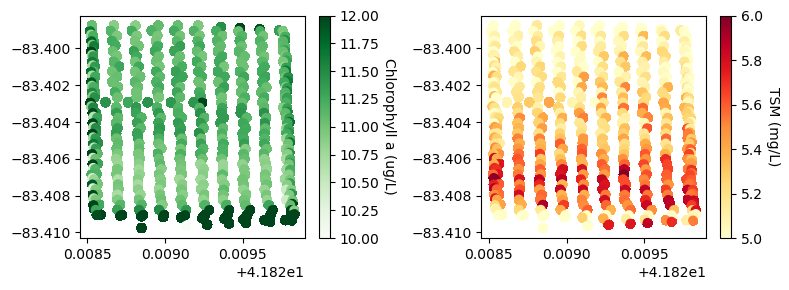

In [230]:
fig, ax = plt.subplots(1,2, figsize=(8,3), layout='tight')
for i in range(len(df)):  
    g1 = ax[0].scatter(df['Latitude'], df['Longitude'], c=df['chl_hu_ocx'], cmap='Greens', vmin=10, vmax=12)
    g2 = ax[1].scatter(df['Latitude'], df['Longitude'], c=df['tsm_nechad'], cmap='YlOrRd', vmin=5, vmax=6)

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270, labelpad=12)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('TSM (mg/L)', rotation=270, labelpad=12)

plt.show()

## 6. Georeference and mosaic chlorophyll a images

We can georeference the images based on the sensor yaw, pitch, roll, lat, lon, and altitude. Note that georeferencing can be inaccurate if the yaw, pitch, and roll information is imprecise. Let's look at the options in the `georeference()` function.

In [104]:
?georeference

Signature:
georeference(
    metadata,
    input_dir,
    output_dir,
    lines=None,
    altitude=None,
    yaw=None,
    pitch=0,
    roll=0,
    axis_to_flip=1,
)
Docstring:
This function georeferences all the captures indicated in the line parameter following the specification of the other parameters such as altitude, yaw, pitch, roll, axis_to_flip

Inputs:
metadata: A Pandas dataframe of the metadata
input_dir: A string containing the directory filepath of the images to be retrieved for georeferencing.
output_dir: A string containing the directory filepath to be saved. 
lines: Selection of images to be processed. Defaults to None. Example: [slice(0,10)]
altitude: sets the altitude where all captures were taken. Defaults to None which uses the altitude data saved in the metadata for each respective capture.
yaw: sets the sensor's direction angle during all captures. Defaults to None which uses the yaw angle saved in the metadata for each respective capture.
pitch: sets the sensor's

We have two options here. We can set fixed georeferencing parameters, or allow the function to use parameters saved in the metadata.

In this example, the image metadata lists the altitude around 260-265 m; however, the altitude was set at 87 m in the flight planning software. Therefore, we will set the altitude to a fixed altitude of 87 m. 

If you can maintain a consistent sensor yaw angle throughout the whole flight, you should use a single fixed angle. If your sensor changes yaw angle during every transect (such as in this example), a different yaw angle should be provided in the function for each transect. The `georeference()` function can read in a `lines` parameter that can be created either manually or you can use the function `compute_flight_lines()` to automatically produce a list of capture indices per transect with the median yaw angle, ignoring capturing collected during turns. More information can be found in the paper.md. 

It is recommended to run the `georeference()` function on a few captures that contain a shoreline or land if possible and plot them with a satellite basemap or pull them into a GIS software to assess the georeferencing. We have provided examples here by manually creating a new folder of rrs_hedley_subset and lt_thumbnails_subset with captures 443 to 450 containing the shoreline.

1. Running `georeference()` with the automatic `compute_flight_lines()` function produces a flight_lines list with yaw angle changing from 207 to 24 degrees:

In [3]:
rrs_hedley_subset, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley_subset', start=432, count=18)
img_metadata = img_metadata.reset_index()

flight_lines = compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)
flight_lines

[{'start': 2,
  'end': 8,
  'yaw': 208.46233933957984,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 10,
  'end': 18,
  'yaw': 25.85588214075483,
  'pitch': 0,
  'roll': 0,
  'alt': 87}]

Edit metadata to change file extension from'.tif' to '.jpg' and run `georeference()` on the lt_thumbnails_subset:

In [7]:
img_metadata['filename'] = img_metadata['filename'].apply(lambda x : x.replace('.tif', '.jpg')) 

input_dir = os.path.join(project_path, 'lt_thumbnails_subset') 
output_dir = os.path.join(project_path, 'automatic_georeferenced_lt_thumbnails_subset')
lines = flight_lines

georeference(img_metadata, input_dir, output_dir, lines) 

100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


Screenshot from QGIS: <br>
<img src="figs/automatic_flightlines_QGIS.png" width=400 height=200/>

You can see that using the metadata yaw angle in georeferencing doesn't always lead to accurate georeferencing. 

2. Running `georeference()` using fixed yaw angles of 90 and 270 degrees:

In [8]:
flight_lines = compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)

even_yaw = 90
odd_yaw = 270
threshold = np.median(img_metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
    
flight_lines

[{'start': 0, 'end': 9, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 10, 'end': 18, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87}]

In [10]:
input_dir = os.path.join(project_path, 'lt_thumbnails_subset') 
output_dir = os.path.join(project_path, 'manual_georeferenced_lt_thumbnails_subset')
lines = flight_lines

georeference(img_metadata, input_dir, output_dir, lines) 

100%|██████████| 17/17 [00:01<00:00, 11.61it/s]


Screenshot from QGIS: <br>
<img src="figs/manual_flightlines_QGIS.png" width=400 height=200/>

You can see that using these fixed yaw angles leads to better georeferencing where the shoreline better matches the satellite basemap.

Therefore, we will use fixed yaw angles of 90 and 270 degrees to georeference the masked_chl_hu_ocx_imgs:

In [75]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))

flight_lines = compute_flight_lines(metadata.Yaw, 87, 0, 0)   
even_yaw = 90
odd_yaw = 270
threshold = np.median(metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
flight_lines[0:5]

[{'start': 11, 'end': 17, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 22, 'end': 32, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 34, 'end': 42, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 46, 'end': 56, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 58, 'end': 66, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87}]

In [47]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
input_dir = os.path.join(project_path, 'masked_chl_hu_ocx_imgs') 
output_dir = os.path.join(project_path, 'georeferenced_masked_chl_hu_ocx')
lines = flight_lines

georeference(metadata, input_dir, output_dir, lines) 

100%|██████████| 328/328 [01:05<00:00,  5.00it/s]


Let's plot a few of these georeferenced images by the shoreline:

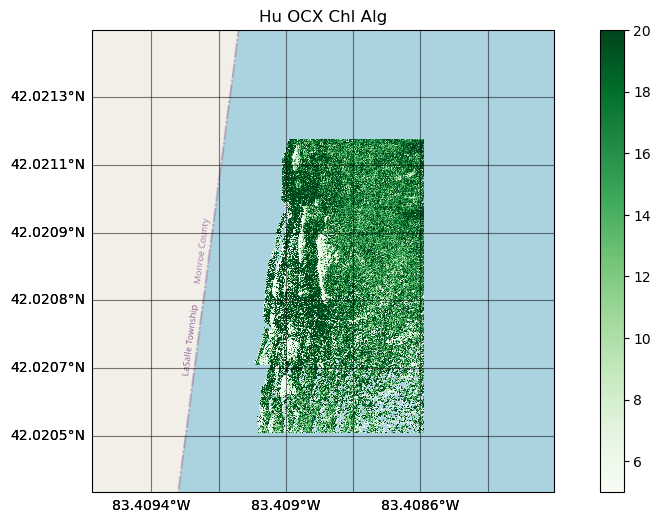

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_444.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_445.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0.set_title('Hu OCX Chl Alg')
plt.colorbar(mappable_0)

We can mosaic all of the individual georeferenced images. Let's look at the options.

In [63]:
?mosaic

Signature:
mosaic(
    input_dir,
    output_dir,
    output_name,
    method='mean',
    dtype=<class 'numpy.float32'>,
    band_names=None,
)
Docstring:
This function moasics all the given rasters into a single raster file 

Inputs:
input_dir: a string containing the directory filepath of images to be mosaicked 
output_dir: a string containing the directory filepath to save the output
output_name: a string of the output name of mosaicked .tif
method: Method to be used when multiple captures coincide at same location. Options: 'mean', 'first', 'min', 'max'. Defaults to 'mean'.
dtype: dtype of the mosaicked raster. Defaults to np.float32.
band_names: List of band names. If it is not None, it writes one file for each band instead of one file with all the bands. Defaults to None.

Returns:
Mosaicked .tif file
File:      /home/jovyan/utils.py
Type:      function

We will make a mosaic from all the georeferenced chl images, calculating the mean of overlapping pixels. 

In [60]:
input_dir = os.path.join(project_path, 'georeferenced_masked_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

mosaic(input_dir, output_dir, output_name = 'mean_mosaic_chl_hu_ocx',
           method='mean', band_names = None) 

100%|██████████| 328/328 [09:20<00:00,  1.71s/it]


'Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif'

Now let's plot the mosaicked image.

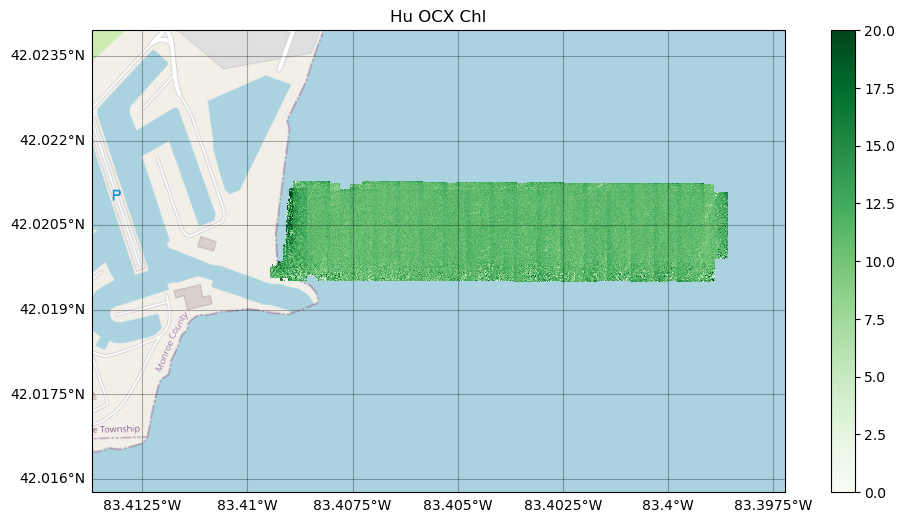

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title('Hu OCX Chl')
plt.colorbar(mappable_0)

We can also downsample or reduce the spatial resolution of the mosaic. This is helpful to reduce the file size of a large mosaic. 

In [65]:
?downsample

Signature:
downsample(
    input_dir,
    output_dir,
    scale_x,
    scale_y,
    method=<Resampling.average: 5>,
)
Docstring:
This function performs a downsampling to reduce the spatial resolution of the final mosaic. 

Inputs:
input_dir: A string containing input directory filepath  
output_dir: A string containing output directory filepath 
scale_x: proportion by which the width of each file will be resized 
scale_y: proportion by which the height of each file will be resized
method: the resampling method to perform. Defaults to Resampling.average.
File:      /glusteruser/awindled/DroneWQ/utils.py
Type:      function

We will downsample the width and height of the mosaic by 15%, calculating the mean of overlapping pixels.

In [65]:
input_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

downsample(input_dir, output_dir, scale_x = 15, scale_y = 15, method = Resampling.nearest)

100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


And we can plot it

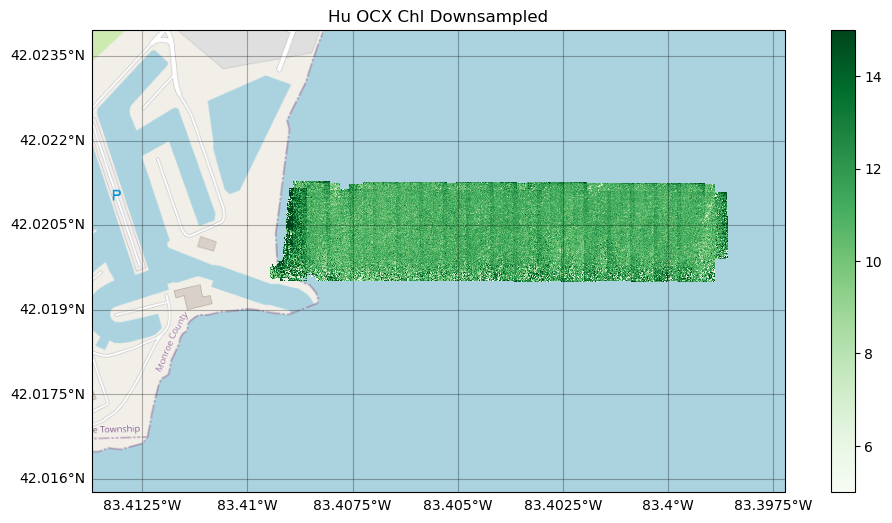

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx_x_15_y_15_method_nearest.tif", 
                                           vmin=5, vmax=15, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title('Hu OCX Chl Downsampled')
plt.colorbar(mappable_0)

And here it is pulled into QGIS: 

<img src="figs/mosaic_QGIS.png" width=400 height=200/>

Some striping in the mosaic is visible due to the drone/sensor changing yaw angles every transect. Processing and mosaicking a larger dataset has the potential to reveal water quality patterns or algal blooms. 